<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="http://introtodeeplearning.com/images/colab/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning_labs/blob/master/lab2/Part1_mnist_solution.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning_labs/blob/master/lab2/Part1_mnist_solution.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>


# Laboratory 2: Computer Vision

# Part 1: MNIST Digit Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First we'll import TensorFlow, enable Eager execution, and also import some dependencies.

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import random
from progressbar import progressbar

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd .. 

# Import the necessary class-specific utility files for this lab
import introtodeeplearning_labs as util

/content/introtodeeplearning_labs
Branch '2019' set up to track remote branch '2019' from 'origin'.
Switched to a new branch '2019'
Already up to date.
/content


## 1.1 MNIST dataset 

Let's download and load the dataset and display a few random samples from it:

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = np.expand_dims(train_images, axis=-1)/255.
train_labels = np.int64(train_labels)
test_images = np.expand_dims(test_images, axis=-1)/255.
test_labels = np.int64(test_labels)

11501568/11490434 [==============================] - 1s 0us/step


Our training set is made up of 28x28 grayscale images of handwritten digits. 

Let's visualize what some of these images and their corresponding training labels look like.

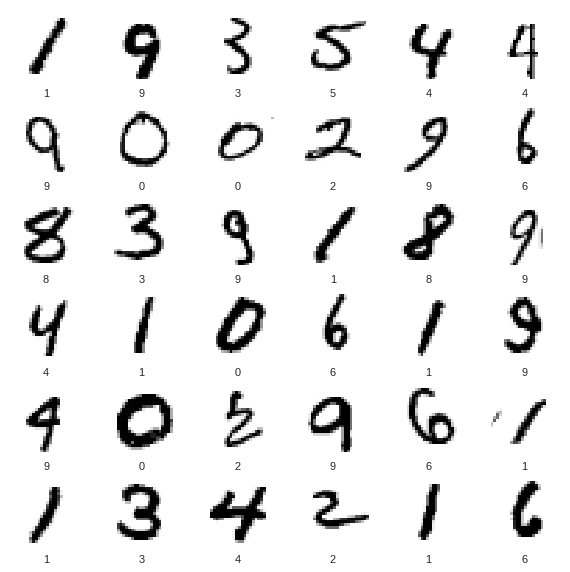

In [0]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

## 1.2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

![alt_text](img/mnist_2layers_arch.png "CNN Architecture for MNIST Classification")


### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the Keras API and define the model using the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) class. Note how we first use a [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model. 

In this next block, you'll define the output layer -- the second fully connected of this simple network.

In [0]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # First define a Flatten layer
      tf.keras.layers.Flatten(),
      # '''TODO: Define the activation function for the first fully connected layer.'''
      tf.keras.layers.Dense(128, activation=tf.nn.relu), # TODO (activation)
      # '''TODO: Define the second Dense layer to output the classification probabilities'''
      tf.keras.layers.Dense(10, activation=tf.nn.softmax) # TODO (both dimension and activation)
  ])
  return fc_model

model = build_fc_model()

As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the model. **

Let's take a step back and think about the network we've just created. The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are fully-connected neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer (which you've defined!) should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model! 



### Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) step:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of .01. Since we are performing a categorical classification task, we'll want to use the [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy).

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model. 

In [0]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=1e-2), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

We're now ready to train our model, which will involve feeding the training data (`train_images` and `train_labels`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training. With the Keras API and defining the model settings in the `compile` step, training is all accomplished by calling the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) method on an instance of the Model class. 


In [0]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 12
EPOCHS = 5

In [0]:
model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.4528 - acc: 0.8782
Epoch 2/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.2519 - acc: 0.9286
Epoch 3/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.2048 - acc: 0.9425
Epoch 4/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.1737 - acc: 0.9509
Epoch 5/5
5000/5000 [==============================] - 55s 11ms/step - loss: 0.1510 - acc: 0.9580


As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.99 (or 99%) on the training data.

### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array. 

Use the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset!

In [0]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(test_images, test_labels) # TODO

print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step
('Test accuracy:', 0.9575)


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*, when a machine learning model performs worse on new data than on its training data. 

What is the highest accuracy you can achieve with this first fully connected model? Since the handwritten digit classification task is pretty straightforward, you may be wondering how we can do better...

![Deeper...](https://i.kym-cdn.com/photos/images/newsfeed/000/534/153/f87.jpg)

## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

As we saw in lecture, convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![alt_text](img/convnet_fig.png "CNN Architecture for MNIST Classification")

### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. 

You can use  [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model!

In [0]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        #'''TODO: Define the first convolutional layer'''
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), input_shape=(28, 28, 1), activation=tf.nn.relu), # TODO        

        #'''TODO: Define the first max pooling layer'''
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # TODO

        #'''TODO: Define the second convolutional layer'''
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu), # TODO

        #'''TODO: Define the second max pooling layer'''
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # TODO

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        #'''TODO: Define the last Dense layer'''
        tf.keras.layers.Dense(10, activation=tf.nn.softmax) # TODO
    ])
    return cnn_model
  
cnn_model = build_cnn_model()
print(cnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 36)        7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 36)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               115328    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total para

### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an optimizer and learning rate of choice:

In [0]:
'''TODO: Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=1e-2), # TODO
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Now we can train our model using the `fit` method via the Keras API:

In [0]:
'''TODO: Train the CNN model'''
cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
5000/5000 [==============================] - 74s 15ms/step - loss: 0.3168 - acc: 0.9034
Epoch 2/5
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0893 - acc: 0.9719
Epoch 3/5
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0647 - acc: 0.9799
Epoch 4/5
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0512 - acc: 0.9845
Epoch 5/5
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0429 - acc: 0.9866


Great! Now that we've trained the model, let's evaluate it on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [0]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels) # TODO

print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 6ms/step
('Test accuracy:', 0.9853)


What is the highest accuracy you're able to achieve using the CNN model, and how does the accuracy of the CNN model compare to the accuracy of the simple fully connected network? What optimizers and learning rates seem to be optimal for training the CNN model? 

### Make predictions with the CNN model

With the model trained, we can use it to make predictions about some images. We'll use the [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict) function call to generate the output predictions given a set of input samples.


In [0]:
predictions = cnn_model.predict(test_images)

With this function call, the model has predicted the label for each image in the testing set. Let's take a look at the prediction for the first image in the test dataset:

In [0]:
predictions[0]

array([5.7147300e-09, 2.2758838e-08, 2.3113976e-06, 1.4349106e-05,
       4.3318557e-11, 3.7796006e-08, 2.0755054e-13, 9.9998295e-01,
       2.9241093e-07, 4.9984450e-08], dtype=float32)

As you can see, a prediction is an array of 10 numbers. Recall that the output of our model is a probability distribution over the 10 digit classes. Thus, these numbers describe the model's "confidence" that the image corresponds to each of the 10 different digits. 

Let's look at the digit that has the highest confidence for the first image in the test dataset:

In [0]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset'''
np.argmax(predictions[0]) # TODO

7

So, the model is most confident that this image is a "7". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

In [0]:
test_labels[0]

7

It is!

We can define a couple of functions to help visualize the classification results on the MNIST dataset. First, we'll write a function, `plot_image`, to plot images along with their predicted label and the probability of the prediction. Second, we'll also define a function, `plot_value_array`, to plot the prediction probabilities for each of the digits. 

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(np.squeeze(img), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's use these functions to visualize the model's predictions for the images in the test dataset: 

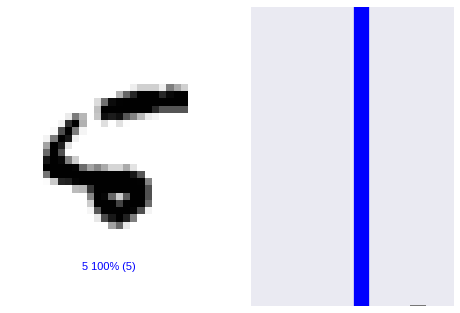

In [0]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 8 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
plot_image(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(image_index, predictions,  test_labels)

We can also plot several images along with their predictions, where correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent confidence (out of 100) for the predicted label. Note the model can be very confident in an incorrect prediction!

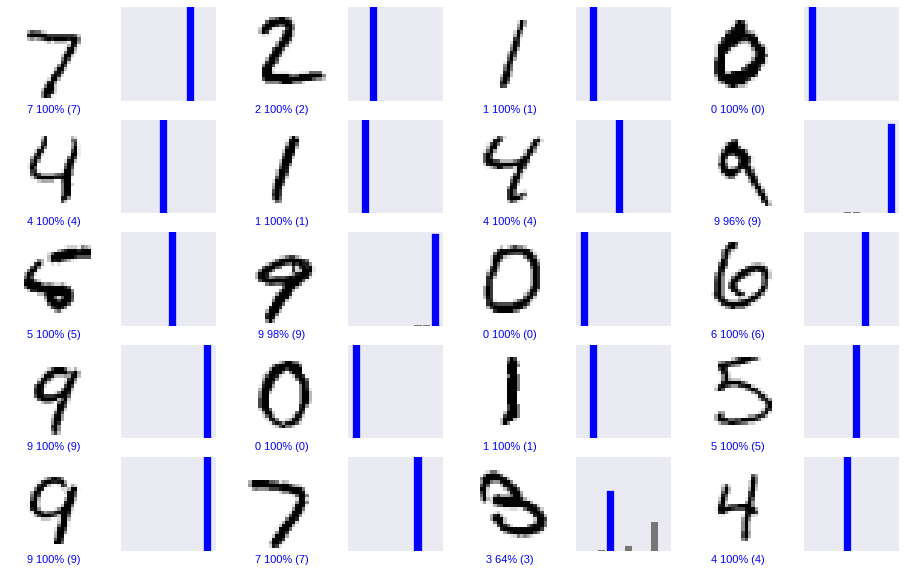

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


## 1.4 Training the model 2.0

Earlier in the lab, we used the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) function call to train the model. This function is quite high-level and intuitive, which is really useful for simpler models. As you may be able to tell, this function abstracts away many details in the training call, and we have less control over training model, which could be useful in other contexts. 

As an alternative to this, we can use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) class to record differentiation operations during training, and then call the [`tf.GradientTape.gradient`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) function to actually compute the gradients. 

You may recall seeing this in Lab 1 Part 1, but let's take another look at this here.

We'll use this framework to train our `cnn_model` using stochastic gradient descent.

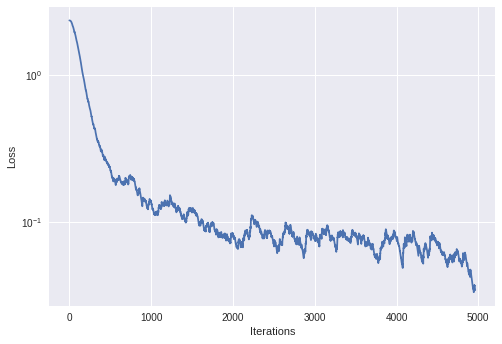

100%|#########################################################|Time:  0:01:05  


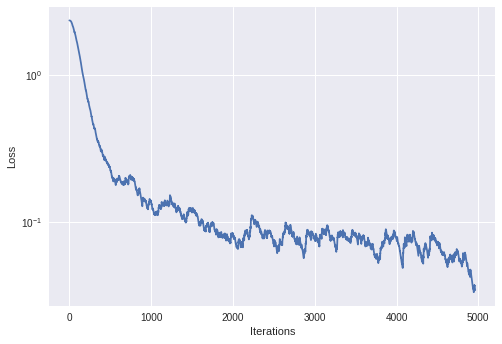

In [0]:
# Rebuild the CNN model
cnn_model = build_cnn_model()

loss_history = util.LossHistory(smoothing_factor=0.99) # to record the evolution of the loss
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2) # define our optimizer

bar = util.create_progress_bar()
for idx in bar(range(0, train_images.shape[0],BATCH_SIZE)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+BATCH_SIZE], train_labels[idx:idx+BATCH_SIZE])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    logits = cnn_model(images) # feed the images into the model
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits) # value of the loss

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())
  # Backpropagation
  grads = tape.gradient(loss_value, cnn_model.variables)
  optimizer.apply_gradients(zip(grads, cnn_model.variables),
                            global_step=tf.train.get_or_create_global_step())
 

## 1.5 Conclusion
In this part of the lab, you had the chance to play with different MNIST classifiers with different architectures (fully-connected layers only, CNN), and experiment with how different hyperparameters affect accuracy (learning rate, etc.). The next part of the lab explores another application of CNNs, facial detection, and some drawbacks of AI systems in real world applications, like issues of bias. 